In [1]:
##获取当前路径
!pwd

/home/htt/桌面/git/some_exp/TABLE


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import random_split
from torch import nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path='../data/watermallon_3.0_alpha.csv'):
        ## 导入数据
        df=pd.read_csv(path)
        ## 文本转onehot
        one_hot_encoded_df = pd.get_dummies(df, columns=['好瓜'],dtype=int)
        one_hot_encoded_df_drop=one_hot_encoded_df.drop(columns=['编号','好瓜_否'])
        self.data=torch.tensor(one_hot_encoded_df_drop.values).float()

    def __getitem__(self, index):
        data=self.data[index]
        x = data[:-1]
        y = data[-1].int()
        return x, y

    def __len__(self):
        return len(self.data)
        
dataset=CustomDataset('../data/watermallon_3.0_alpha.csv')
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# 拆分数据集
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)



In [4]:
def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator: 
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [139]:
def maximum_likelihood(y_hat, y):
    '''y_hat=torch.squeeze(y_hat,1)
    p_yi_xi_wb_=y*y_hat+(1-y)*(1-y_hat)
    p=torch.log(p_yi_xi_wb_)'''#
    
    y_hat=torch.squeeze(y_hat,1)
    p=(-y)*y_hat+torch.log(1+torch.exp(y_hat))
    return p 


def crossentropy(y_hat, y):
    y_hat=torch.squeeze(y_hat,1)
    p=y*torch.log(y_hat)+(1-y)*torch.log(1-y_hat)
    return -p
    
def accuracy_(y_hat, y):
    """计算预测正确的数量"""
    #y_hat=torch.squeeze(y_hat,1)
    y_hat[y_hat>0.5]=1
    y_hat[y_hat<0.5]=0
    right_count=(y_hat == y).sum()

    #cmp = y_hat.type(y.dtype) == y
    return right_count#float(right_count/len(y))#float(cmp.type(y.dtype).sum())

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    y_hat=torch.squeeze(y_hat,1)
    y_hat[y_hat>=0.5]=1
    y_hat[y_hat<0.5]=0
    right_count=(y_hat == y).sum()

    #cmp = y_hat.type(y.dtype) == y
    return right_count


def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        #print(l)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()#l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.mean().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    #assert train_loss < 0.5, train_loss
    #assert train_acc <= 1 and train_acc > 0.7, train_acc
    #assert test_acc <= 1 and test_acc > 0.7, test_acc

AssertionError: 0.6635363260904948

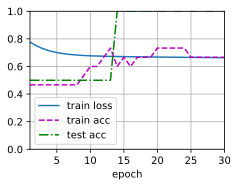

In [143]:
##### 定义模型和优化器
model = nn.Sequential(nn.Linear(2,1),nn.Sigmoid())  # 定义模型
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.5,std=0.01)
        print(m.weight)
model.apply(init_weights)

#loss = maximum_likelihood#nn.CrossEntropyLoss(reduction='none') 
optimizer = torch.optim.SGD(model.parameters(), lr=0.5) # 定义优化器
num_epochs = 30
train_ch3(model, train_loader, test_loader, crossentropy, num_epochs,optimizer)

In [45]:
m = nn.Sigmoid()
input = torch.randn(2)
output = m(input)
output

tensor([0.7853, 0.2028])

In [110]:
model = nn.Sequential(nn.Linear(2, 1))#,nn.Sigmoid())#)#
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.5,std=0.01)
        print(m.weight)

model.apply(init_weights)

def maximum_likelihood(y_hat, y):
    '''y_hat=torch.squeeze(y_hat,1)
    p_yi_xi_wb_=y*y_hat+(1-y)*(1-y_hat)
    p=torch.log(p_yi_xi_wb_)'''#
    
    y_hat=torch.squeeze(y_hat,1)
    p=-y*y_hat+torch.log(1+torch.exp(y_hat))
    print(y,p)

    return p 
for epoch in range(num_epochs):
    for X, y in train_loader:
        y_hat = model(X)
        #print(y_hat)
        l = maximum_likelihood(y_hat, y)
        #print(l)

        optimizer.zero_grad()
        l.sum().backward()
        optimizer.step()
        
        #print(model.parameters())
    

Parameter containing:
tensor([[0.9935, 1.0125]], requires_grad=True)
tensor([[ 0.1571],
        [ 0.0923],
        [ 0.4967],
        [-0.0298],
        [ 0.4881],
        [-0.3604],
        [-0.1498],
        [-0.0137],
        [ 0.2357],
        [ 0.1086],
        [-0.0212],
        [ 0.1917],
        [-0.0328],
        [-0.2205],
        [ 0.0708]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0], dtype=torch.int32) tensor([0.7748, 0.7404, 0.4753, 0.6783, 0.4786, 0.5291, 0.6211, 0.7000, 0.5822,
        0.6403, 0.7038, 0.7936, 0.7097, 0.5890, 0.7292],
       grad_fn=<AddBackward0>)
tensor([[-0.2991],
        [ 0.1099],
        [ 0.0080],
        [ 0.1558],
        [ 0.0722],
        [ 0.4083],
        [-0.1126],
        [-0.1140],
        [-0.2229],
        [ 0.0289],
        [-0.0021],
        [-0.0914],
        [-0.4382],
        [ 0.4201],
        [-0.0977]], grad_fn=<AddmmBackward0>)
tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1], dtype=torch.

In [137]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    y_hat=torch.squeeze(y_hat,1)
    #print(y_hat)
    y_hat[y_hat>=0.5]=1
    #print(y_hat)
    y_hat[y_hat<0.5]=0
    #print(y_hat)
    print(y,y_hat)
    right_count=(y_hat == y).sum()
    #cmp = y_hat.type(y.dtype) == y
    return right_count
    
def maximum_likelihood(y_hat, y):
    '''y_hat=torch.squeeze(y_hat,1)
    p_yi_xi_wb_=y*y_hat+(1-y)*(1-y_hat)
    p=torch.log(p_yi_xi_wb_)#
    print(y,y_hat)'''
    y_hat=torch.squeeze(y_hat,1)
    p=-y*y_hat+torch.log(1+torch.exp(y_hat))
    #print(y,p)
    return p 

def crossentropy(y_hat, y):
    y_hat=torch.squeeze(y_hat,1)
    p=y*torch.log(y_hat)+(1-y)*torch.log(1-y_hat)
    return -p
    
model = nn.Sequential(nn.Linear(2, 1),nn.Sigmoid())#
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.5,std=0.01)
        print(m.weight)
model.apply(init_weights)

optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for epoch in range(num_epochs):
    for X, y in train_loader:
        y_hat = model(X)
        #print(y_hat)
        l = crossentropy(y_hat, y)
        #print(l)
        optimizer.zero_grad()
        l.mean().backward()
        optimizer.step()
        accurary_=accuracy(y_hat, y)/len(y)
        print(accurary_)
        #print(model.parameters())
    

Parameter containing:
tensor([[0.4943, 0.5012]], requires_grad=True)
tensor([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0], dtype=torch.int32) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<AsStridedBackward0>)
tensor(0.4667)
tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1], dtype=torch.int32) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<AsStridedBackward0>)
tensor(0.4667)
tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1], dtype=torch.int32) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<AsStridedBackward0>)
tensor(0.4667)
tensor([1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1], dtype=torch.int32) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_fn=<AsStridedBackward0>)
tensor(0.4667)
tensor([0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], dtype=torch.int32) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       grad_f